In [1]:
import time
from typing import Optional, Tuple, List

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader

In [2]:
torch.cuda.is_available()

True

In [3]:
torch.__version__

'1.13.1+cu117'

In [4]:
from torchvision import datasets
from torchvision.transforms import ToTensor

train_data = datasets.MNIST(
    root='../models/mnist',
    train=True,
    transform=ToTensor(),
    download=True,
)

test_data = datasets.MNIST(
    root='../models/mnist',
    train=False,
    transform=ToTensor(),
    download=True,
)

In [5]:
class TrainHelper:
    @staticmethod
    def train(cnn: nn.Module,
              *,
              epochs: int,
              train_dataset: datasets.MNIST,
              test_dataset: Optional[datasets.MNIST] = None,
              print_results: bool = True,
              batch_size: int,
              device_name: str) -> List[float]:

        train_loader = torch.utils.data.DataLoader(train_dataset,
                                                   batch_size=batch_size,
                                                   shuffle=True,
                                                   num_workers=1)

        device = torch.device(device_name)

        cnn.to(device)
        cnn.train()

        optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001)
        loss_func = nn.CrossEntropyLoss()

        eval_results: List[float] = []

        for epoch in range(epochs):
            for images, labels in train_loader:
                images = Variable(images.to(device))
                labels = Variable(labels.to(device))

                output = cnn(images)
                loss = loss_func(output, labels)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            if test_dataset is not None:
                eval_result = TrainHelper.test(cnn, test_dataset, device)
                eval_results.append(eval_result)
                if print_results:
                    print(f"epoch {epoch}, accuracy = {eval_result}, loss = {loss.detach()}")
                cnn.train()

        return eval_results

    @staticmethod
    def test(cnn: nn.Module, test_dataset: datasets.MNIST, device=None) -> float:
        cnn.eval()
        loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=1)
        correct = 0
        incorrect = 0

        for images, labels in loader:
            if device is not None:
                images = images.to(device)

            results = cnn(images)
            predictions = results.detach().cpu().numpy().argmax(axis=1)
            oks = (predictions == labels.numpy()).sum()
            correct += oks
            incorrect += len(predictions) - oks

        return correct / (correct + incorrect)

    @staticmethod
    def train_models(models: List[nn.Module], device_name: str) -> Tuple[int, float]:
        """
        generator yields pair (trainable parameters count, best accuracy) for each network
        :param device_name: 'cuda' or 'cpu'
        """
        assert len(models) > 0

        for model in models:
            start = time.time()
            eval_results = TrainHelper.train(
                cnn=model,
                epochs=20,
                train_dataset=train_data,
                test_dataset=test_data,
                batch_size=512,
                device_name=device_name,
                print_results=False
            )
            end = time.time()
            best_acc = max(eval_results)
            params_count = TrainHelper.total_parameters_count(model)
            print(f"best accuracy = {best_acc}, parameters = {params_count}, training time = {end - start}")
            yield params_count, best_acc

    @staticmethod
    def total_parameters_count(model: nn.Module) -> int:
        return sum(np.prod(p.size()) for p in model.parameters())

    @staticmethod
    def print_parameters(model: nn.Module):
        print(f"total parameters = {TrainHelper.total_parameters_count(model)}")
        for p in model.parameters():
            print(f"size {np.prod(p.size())}: {p.size()}")

In [6]:
from dataclasses import dataclass
import torch.nn.functional as F


@dataclass(eq=True, unsafe_hash=True, frozen=True)
class Mode:
    is_maxpool: bool

    @staticmethod
    def all() -> List['Mode']:
        return [Mode(True), Mode(False)]


class DownSample(nn.Module):
    def __init__(self, mode: Mode):
        super(DownSample, self).__init__()
        self.mode = mode

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        _, _, h, w = x.size()

        if self.mode.is_maxpool:
            x = F.max_pool2d(x, kernel_size=2)
        else:
            x = x[:, :, ::2, ::2]

        _, _, h2, w2 = x.size()
        assert h == h2 * 2 and w == w2 * 2, f"{h}, {w} -> {h2}, {w2}"

        return x


class MyConvModel(nn.Module):
    def __init__(self, channels: int, mode: Mode):
        super(MyConvModel, self).__init__()

        c = channels

        self.layers = nn.Sequential(
            self.conv(1, c, kernel_size=3),          # 28 - 26
            self.conv(c, c, kernel_size=3),          # 26 - 24
            DownSample(mode),                        # 24 - 12

            self.conv(c, c * 2, kernel_size=3),      # 12 - 10
            self.conv(c * 2, c * 2, kernel_size=3),  # 10 - 8
            DownSample(mode),                        # 8 - 4

            self.conv(c * 2, c * 4, kernel_size=3),  # 4 - 2
            self.conv(c * 4, c * 4, kernel_size=2),  # 2 - 1

            nn.Conv2d(c * 4, 10, kernel_size=1, padding='valid', bias=True),
            nn.Flatten(),
        )

    def conv(self, in_ch: int, out_ch: int, *, kernel_size: int):
        layers = []

        layers += [
            nn.Conv2d(in_ch, out_ch, kernel_size=kernel_size, padding='valid', bias=False),
            nn.BatchNorm2d(out_ch),
            nn.LeakyReLU(0.1)
        ]
        return nn.Sequential(*layers)

    def forward(self, x: torch.Tensor):
        return self.layers(x)

In [7]:
results = {
    mode: [] for mode in Mode.all()
}

In [8]:
device_name = 'cuda' if torch.cuda.is_available() else 'cpu'

for i in range(4):
    for mode in Mode.all():
        models = [MyConvModel(ch, mode) for ch in reversed([4, 8, 16, 32, 64])]
        for pair in TrainHelper.train_models(models, device_name=device_name):
            results[mode].append(pair)

best accuracy = 0.9951, parameters = 820042, training time = 95.75381255149841
best accuracy = 0.9954, parameters = 206250, training time = 85.70330929756165
best accuracy = 0.994, parameters = 52186, training time = 85.86848711967468
best accuracy = 0.9926, parameters = 13362, training time = 85.41477704048157
best accuracy = 0.9888, parameters = 3502, training time = 84.98410701751709
best accuracy = 0.9942, parameters = 820042, training time = 92.54103970527649
best accuracy = 0.9942, parameters = 206250, training time = 86.11086249351501
best accuracy = 0.9924, parameters = 52186, training time = 86.48298168182373
best accuracy = 0.9909, parameters = 13362, training time = 85.9820773601532
best accuracy = 0.989, parameters = 3502, training time = 86.48986864089966
best accuracy = 0.9957, parameters = 820042, training time = 92.1361517906189
best accuracy = 0.9951, parameters = 206250, training time = 86.9450945854187
best accuracy = 0.9945, parameters = 52186, training time = 86.32

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


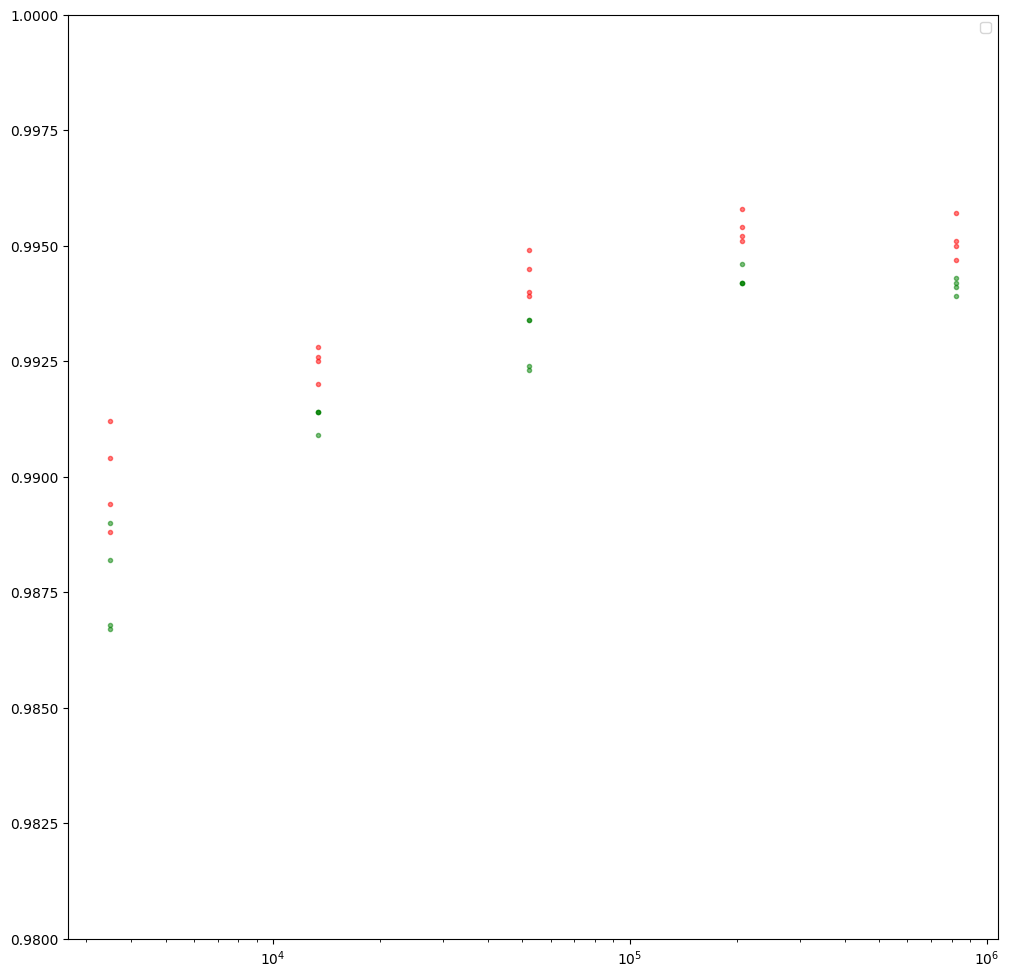

In [9]:
plt.rcParams['figure.figsize'] = [12, 12]
fig, ax = plt.subplots()
ax.set_xscale("log")
ax.set_ylim(0.98, 1)

modes = Mode.all()
colors = {
    modes[0]: 'red',
    modes[1]: 'green',
}

for mode in modes:
    ax.scatter([p[0] for p in results[mode]], [p[1] for p in results[mode]], c=colors[mode], alpha=0.5, marker=r'.')

ax.legend()
plt.show()